In [1]:
import sys
sys.path.append("../")

In [23]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml

import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, log_loss
from sklearn.utils.class_weight import compute_class_weight

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

from xgboost import XGBClassifier

from utils.load_data import *
from utils.metrics import get_token_set_ratio
from utils.group_similar_strings import group_similar_strings

### Load data

In [3]:
with open("../config.yml", "r") as file:
    config = yaml.safe_load(file)

In [4]:
df_input = (
      pl.scan_csv ('../temp_folder/SG_cossim.csv', separator=";")
      .filter(pl.col('similarity_sg')>0.2)
      .join(pl.scan_csv ('../temp_folder/ST_cossim.csv', separator=";"),
            on = ['left_side', 'right_side'], 
            how ='left')
      .join(pl.scan_csv ('../temp_folder/SGWords_cossim.csv', separator=";")
            .rename({'similarity_sg': 'similarity_sgWords'}),
            on = ['left_side', 'right_side'], 
            how ='left')
      .join(pl.scan_csv ('../temp_folder/Nomenclature_cossim.csv', separator=";"), 
            on = ['left_side', 'right_side'], 
            how ='left')
      .join(pl.scan_csv ('../temp_folder/Nomenclature_words_cossim.csv', separator=";")
            .rename({'similarity_sg': 'similarity_nomenclatureWords'}), 
            on = ['left_side', 'right_side'], 
            how ='left')
    .filter(pl.col('left_side')!=pl.col('right_side'))
    .fill_null(0)
    .collect()
)

df_input = get_token_set_ratio(df_input)

print(df_input.shape)

df_input.write_csv('../temp_folder/features_for_classification.csv', separator=";")

(64666, 8)


### Split train and test set

In [5]:
df_input_target = (
    df_input
    .join(  
        pl.read_csv ('../temp_folder/training_dataset.csv', separator=";"),
        on = ['left_side', 'right_side'], 
        how ='inner')
)
df_input_target.shape
    
df_input_target_pd = df_input_target.to_pandas()

print(sorted(Counter(df_input_target_pd['target']).items()))
   

[(0, 5584), (1, 580)]


In [65]:
label_var = ['left_side', 'right_side']

target_var = 'target'

indicators_var = ['similarity_sg', 
                  'similarity_sgWords',
                  'similarity_st', 
                  'similarity_nomenclature', 
                  'similarity_nomenclatureWords',
                  'token_set_ratio',
                  ]

label = df_input_target_pd[label_var]

X = df_input_target_pd[indicators_var]

Y = df_input_target_pd[target_var]

# Splitting the data into train and test
# we are stratifying on the label to ensure we receive a similar proportion of matched items in each set
label_train, label_test, X_train, X_test, Y_train, Y_test = train_test_split(label, X, Y, test_size = 0.3, random_state=42, stratify=Y)
print(X_train.shape)
print(X_test.shape)

print(sorted(Counter(Y_train).items()))
print(sorted(Counter(Y_test).items()))

(4314, 6)
(1850, 6)
[(0, 3908), (1, 406)]
[(0, 1676), (1, 174)]


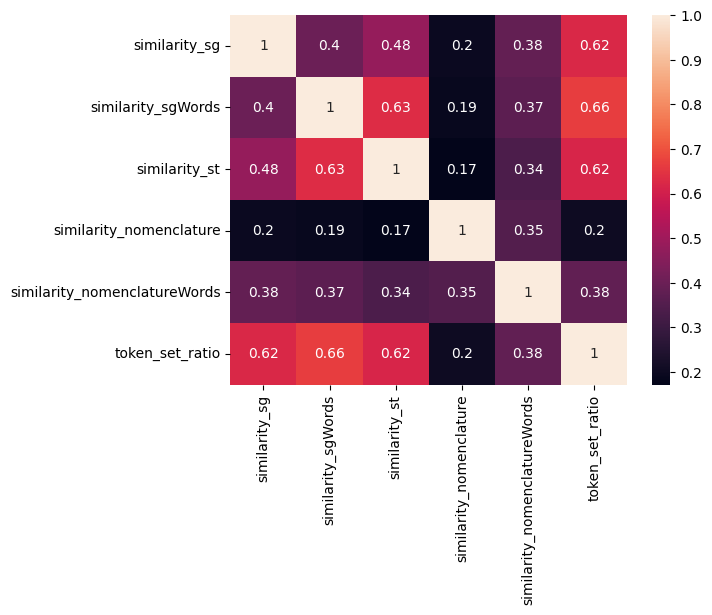

In [8]:
corr = df_input.select(indicators_var).to_pandas().corr()   
heatmap = sns.heatmap(corr, annot=True)

### Random Forest Classifier

In [9]:
# Create and train model
rfc = RandomForestClassifier(random_state=42, class_weight='balanced')

# Fit model
rfc.fit(X_train.drop('similarity_nomenclature', axis=1), Y_train)

# Performance on train
train_y_pred = rfc.predict(X_train.drop('similarity_nomenclature', axis=1))
print("Performance train : ")
print("log loss : ", log_loss(Y_train, train_y_pred))
print("auc : ", roc_auc_score(Y_train, train_y_pred))

# Performance on test
test_y_pred = rfc.predict(X_test.drop('similarity_nomenclature', axis=1))
print("Performance test : ")
print("log loss : ", log_loss(Y_test, test_y_pred))
print("auc : ", roc_auc_score(Y_test, test_y_pred))

# Create confusion matrix
print(confusion_matrix(Y_test, test_y_pred))

Performance train : 
log loss :  2.220446049250313e-16
auc :  1.0
Performance test : 
log loss :  0.2337966706321115
auc :  0.9706677091048748
[[1674    2]
 [  10  164]]


In [18]:
# Step 2: Tune max_depth and min_child_weight
param_grid = { 
    'n_estimators': [300, 500],
    # 'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4, 6, 8, 10],
}

gsearch1 = GridSearchCV(estimator = RandomForestClassifier(random_state=42, class_weight='balanced'), 
                        param_grid = param_grid,  
                        scoring='neg_log_loss',
                        cv=5)

gsearch1.fit(X_train.drop('similarity_nomenclature', axis=1), Y_train)

# for i in ['mean_test_score', 'std_test_score']:
#   print(i," : ",gsearch1.cv_results_[i])
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 12, 'n_estimators': 300}, -0.0441103123299567)

In [19]:
# Create and train model
rfc = RandomForestClassifier(random_state=42, class_weight='balanced', 
                             max_depth=10, n_estimators=300)

# Fit model
rfc.fit(X_train.drop('similarity_nomenclature', axis=1), Y_train)

# Performance on train
train_y_pred = rfc.predict(X_train.drop('similarity_nomenclature', axis=1))
print("Performance train : ")
print("log loss : ", log_loss(Y_train, train_y_pred))
print("auc : ", roc_auc_score(Y_train, train_y_pred))

# Performance on test
test_y_pred = rfc.predict(X_test.drop('similarity_nomenclature', axis=1))
print("Performance test : ")
print("log loss : ", log_loss(Y_test, test_y_pred))
print("auc : ", roc_auc_score(Y_test, test_y_pred))

# Create confusion matrix
print(confusion_matrix(Y_test, test_y_pred))

Performance train : 
log loss :  0.16710085020453036
auc :  0.9974411463664278
Performance test : 
log loss :  0.3312119500621578
auc :  0.9769017639151784
[[1666   10]
 [   7  167]]


,cols,imp
4,token_set_ratio,0.314573
0,similarity_sg,0.296847
2,similarity_st,0.247196
1,similarity_sgWords,0.079174
3,similarity_nomenclatureWords,0.062210


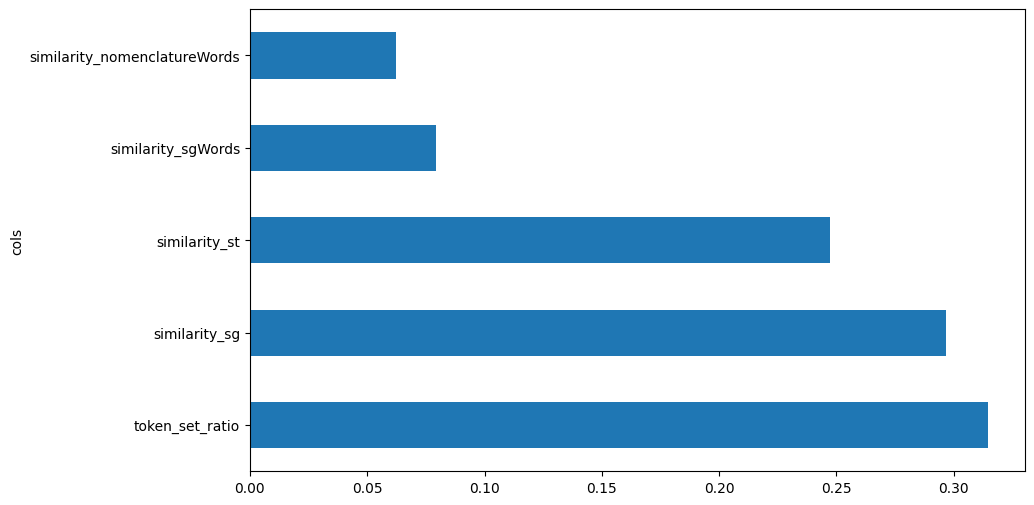

In [20]:
fi = pd.DataFrame({'cols':X_train.drop('similarity_nomenclature', axis=1).columns, 'imp':rfc.feature_importances_}).sort_values('imp', ascending=False)
fi[:30].plot('cols', 'imp', 'barh', figsize=(10,6), legend=False)
fi

In [21]:
res_predicted_test_pd = (
    pd.concat([pd.concat([label_test, X_test.drop('similarity_nomenclature', axis=1), Y_test], axis=1).reset_index(), 
               pd.DataFrame(rfc.predict(X_test.drop('similarity_nomenclature', axis=1)), columns=[f'{target_var}_predicted']),
               pd.DataFrame(rfc.predict_proba(X_test.drop('similarity_nomenclature', axis=1)), columns=['proba_0', 'proba_1'])],
                axis=1)
)

res_predicted_test =  pl.from_pandas(res_predicted_test_pd)
res_predicted_test
res_predicted_test.write_csv('../temp_folder/res_predicted_RFC_test.csv', separator=";")

#### Pipeline

In [ ]:
# classifiers =[
#     RandomForestClassifier(n_estimators=300),
#     ExtraTreesClassifier(n_estimators=300)
# ]

# methods = [
#     SMOTE(random_state=0),
#     SMOTEENN(random_state=0),
#     SMOTETomek(random_state=0)
# ]

In [ ]:
# # Benchmarks
# for classifier in classifiers:
        
#     steps = [('model', classifier)]

#     pipeline = Pipeline(steps=steps)

#     scores = cross_val_score(pipeline, X_train, Y_train, scoring='roc_auc', cv=5)

#     print("ROC-AUC Score for", classifier, "without resampling is", round(np.mean(scores),5))

In [ ]:
# # Iterates over classifiers and methods
# for classifier in classifiers:
#     for method in methods:
        
#         steps = [('method', method),
#                  ('model', classifier)]

#         pipeline = Pipeline(steps=steps)

#         scores = cross_val_score(pipeline, X_train, Y_train, scoring='roc_auc', cv=5)
    
#         print("ROC-AUC Score for", classifier, "and", method, "is", np.mean(scores))

In [ ]:
# rfc_pipeline = Pipeline(steps=[
#                 ('method', SMOTEENN(random_state=0)),
#                 ('model', RandomForestClassifier(n_estimators=300))
#             ])

# rfc_pipeline.fit(X_train, Y_train)

### XGBoost Classifier

In [24]:
# define positive class scaling factor
weights = compute_class_weight(
  'balanced', 
  classes=np.unique(Y_train), 
  y=Y_train
  )
scale = weights[1]/weights[0]

model = XGBClassifier(scale_pos_weight=scale)
# Add silent=True to avoid printing out updates with each cycle
model.fit(X_train, Y_train, verbose=False)

# Performance on train
train_y_pred = model.predict(X_train)
print("Performance train : ")
print("log loss : ", log_loss(Y_train, train_y_pred))
print("auc : ", roc_auc_score(Y_train, train_y_pred))

# Performance on test
test_y_pred = model.predict(X_test)
print("Performance test : ")
print("log loss : ", log_loss(Y_test, test_y_pred))
print("auc : ", roc_auc_score(Y_test, test_y_pred))

Performance train : 
log loss :  2.220446049250313e-16
auc :  1.0
Performance test : 
log loss :  0.27276278240413004
auc :  0.9803719858447865


C:\Users\audec\AppData\Local\Temp\ipykernel_106992\1986263946.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


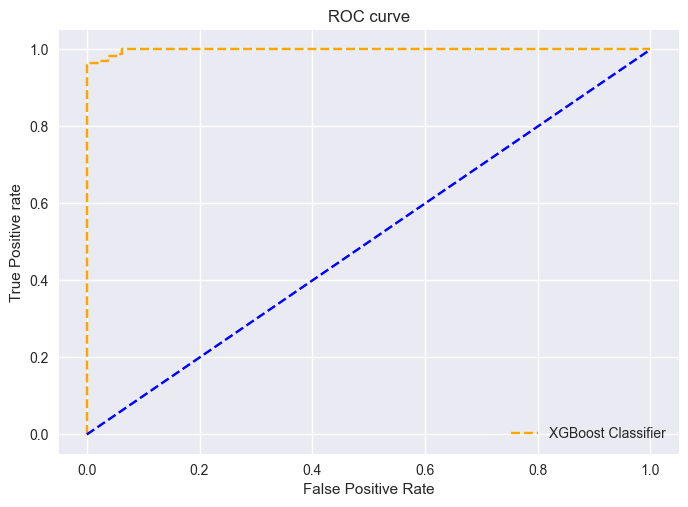

In [25]:
# predict probabilities
pred_prob1 = model.predict_proba(X_test)

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(Y_test, pred_prob1[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(Y_test))]
p_fpr, p_tpr, _ = roc_curve(Y_test, random_probs, pos_label=1)

plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='XGBoost Classifier')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.show()

In [26]:
model = XGBClassifier(n_estimators=100, scale_pos_weight=scale)
model.fit(X_train, Y_train, early_stopping_rounds=10, eval_set=[(X_test, Y_test)], verbose=False)

# Performance on train
train_y_pred = model.predict(X_train)
print("Performance train : ")
print("log loss : ", log_loss(Y_train, train_y_pred))
print("auc : ", roc_auc_score(Y_train, train_y_pred))

# Performance on test
test_y_pred = model.predict(X_test)
print("Performance test : ")
print("log loss : ", log_loss(Y_test, test_y_pred))
print("auc : ", roc_auc_score(Y_test, test_y_pred))

Performance train : 
log loss :  0.01671008502045324
auc :  0.9997441146366428
Performance test : 
log loss :  0.3312119500621578
auc :  0.9794769977779607


c:\Users\audec\Documents\fuzzy_matching\venv\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [27]:
## Step 1:Fix learning rate and number of estimators for tuning tree-based parameters
xgb1 = XGBClassifier(
    learning_rate=0.1, 
    n_estimators=100,
    max_depth=9, 
    min_child_weight=1, 
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic', 
    scale_pos_weight=scale)

# modelfit(xgb1, train, train_X)
xgb1.fit(X_train, Y_train)

# Performance on train
train_y_pred = xgb1.predict(X_train)
print("Performance train : ")
print("log loss : ", log_loss(Y_train, train_y_pred))
print("auc : ", roc_auc_score(Y_train, train_y_pred))

# Performance on test
test_y_pred = xgb1.predict(X_test)
print("Performance test : ")
print("log loss : ", log_loss(Y_test, test_y_pred))
print("auc : ", roc_auc_score(Y_test, test_y_pred))

Performance train : 
log loss :  0.05848529757158577
auc :  0.9991044012282497
Performance test : 
log loss :  0.3117288941761486
auc :  0.9797753271335694


In [46]:
# Step 2: Tune max_depth and min_child_weight
param_test1 = {
    'max_depth':range(3,15,1),
    'min_child_weight':range(1,6,1)
}
rsearch1 = RandomizedSearchCV(estimator = XGBClassifier(learning_rate =0.1, 
                                                  n_estimators=100, 
                                                  max_depth=5,
                                                  min_child_weight=1,
                                                  gamma=0, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic', 
                                                  scale_pos_weight=scale), 
                        param_distributions = param_test1, 
                        scoring='neg_log_loss',
                        n_jobs=4,
                        cv=5)

rsearch1.fit(X_train, Y_train)

for i in ['mean_test_score', 'std_test_score']:
  print(i," : ",rsearch1.cv_results_[i])
rsearch1.best_params_, rsearch1.best_score_

mean_test_score  :  [-0.04130858 -0.05190899 -0.03668197 -0.04237403 -0.05248679 -0.03868267
 -0.04588682 -0.04265091 -0.0352696  -0.03725415]
std_test_score  :  [0.0054312  0.00219173 0.00539512 0.0039398  0.00227525 0.00418353
 0.00312273 0.00370206 0.00558395 0.0055553 ]


({'min_child_weight': 1, 'max_depth': 8}, -0.035269603577441536)

In [47]:
# Fix new param with optimal parameter
xgb2 = XGBClassifier(
    learning_rate=0.1, 
    n_estimators=100,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic', 
    scale_pos_weight=scale,
    max_depth = 8,
    min_child_weight = 1
)
# modelfit(xgb2, train, train_X)
xgb2.fit(X_train, Y_train)

# Performance on train
train_y_pred = xgb2.predict(X_train)
print("Performance train : ")
print("log loss : ", log_loss(Y_train, train_y_pred))
print("auc : ", roc_auc_score(Y_train, train_y_pred))

# Performance on test
test_y_pred = xgb2.predict(X_test)
print("Performance test : ")
print("log loss : ", log_loss(Y_test, test_y_pred))
print("auc : ", roc_auc_score(Y_test, test_y_pred))

Performance train : 
log loss :  0.06684034008181228
auc :  0.9989764585465711
Performance test : 
log loss :  0.3312119500621578
auc :  0.9794769977779607


In [48]:
# Step 3: Tune gamma
param_test3 = { 
    'gamma':list(np.linspace(0.05, 0.5, 10))
}
rsearch3 = RandomizedSearchCV(estimator = XGBClassifier(learning_rate=0.1, 
                                                  n_estimators=100, 
                                                  max_depth=8,
                                                  min_child_weight=1,
                                                  gamma=0, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic', 
                                                  scale_pos_weight=scale), 
                        param_distributions = param_test3, 
                        scoring='neg_log_loss',
                        n_jobs=4,
                        cv=5)

rsearch3.fit(X_train, Y_train)

for i in ['mean_test_score', 'std_test_score']:
  print(i," : ",rsearch3.cv_results_[i])
rsearch3.best_params_, rsearch3.best_score_

mean_test_score  :  [-0.03524766 -0.03493394 -0.03488907 -0.03499934 -0.0355567  -0.03614306
 -0.03541629 -0.03551073 -0.03595972 -0.03575798]
std_test_score  :  [0.00579798 0.0056899  0.00632563 0.0053732  0.00619078 0.00617652
 0.0059201  0.00569563 0.00573195 0.00450267]


({'gamma': 0.15000000000000002}, -0.034889065924947435)

In [49]:
# Fix new param with optimal parameter
xgb3 = XGBClassifier(
    learning_rate=0.1, 
    n_estimators=100,
    gamma=0.15,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic', 
    scale_pos_weight=scale,
    max_depth = 8,
    min_child_weight = 1
)
# modelfit(xgb3, train, train_X)
xgb3.fit(X_train, Y_train)

# Performance on train
train_y_pred = xgb3.predict(X_train)
print("Performance train : ")
print("log loss : ", log_loss(Y_train, train_y_pred))
print("auc : ", roc_auc_score(Y_train, train_y_pred))

# Performance on test
test_y_pred = xgb3.predict(X_test)
print("Performance test : ")
print("log loss : ", log_loss(Y_test, test_y_pred))
print("auc : ", roc_auc_score(Y_test, test_y_pred))

Performance train : 
log loss :  0.05848529757158577
auc :  0.9991044012282497
Performance test : 
log loss :  0.2922458382901393
auc :  0.980073656489178


In [50]:
# Step 4: Tune subsample and colsample_bytree
param_test4 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, 
                                                  n_estimators=100, 
                                                  max_depth = 8,
                                                  min_child_weight = 1,
                                                  gamma=0.15, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic',
                                                  scale_pos_weight=scale), 
                        param_grid = param_test4, 
                        scoring='neg_log_loss',
                        n_jobs=4,
                        cv=5)

gsearch4.fit(X_train,Y_train)

for i in ['mean_test_score', 'std_test_score']:
  print(i," : ",gsearch4.cv_results_[i])
gsearch4.best_params_, gsearch4.best_score_

mean_test_score  :  [-0.03503313 -0.03480155 -0.03450649 -0.03345319 -0.0363722  -0.03547122
 -0.03488907 -0.0345032  -0.0363722  -0.03547122 -0.03488907 -0.0345032
 -0.03602045 -0.03475075 -0.03630534 -0.03473992]
std_test_score  :  [0.00439126 0.00518532 0.00468535 0.00529366 0.00518774 0.00655948
 0.00632563 0.0059356  0.00518774 0.00655948 0.00632563 0.0059356
 0.00649878 0.00661652 0.00585558 0.00713546]


({'colsample_bytree': 0.6, 'subsample': 0.9}, -0.03345319174467047)

In [53]:
# Fix new param with optimal parameter
xgb4 = XGBClassifier(
    learning_rate=0.1, 
    n_estimators=100,
    gamma=0.15,
    subsample=0.8,
    colsample_bytree=0.8,
    max_depth=8,
    min_child_weight = 1,
    objective= 'binary:logistic', 
    scale_pos_weight=scale
)
# modelfit(xgb1, train, train_X)
xgb4.fit(X_train, Y_train)

# Performance on train
train_y_pred = xgb4.predict(X_train)
print("Performance train : ")
print("log loss : ", log_loss(Y_train, train_y_pred))
print("auc : ", roc_auc_score(Y_train, train_y_pred))

# Performance on test
test_y_pred = xgb4.predict(X_test)
print("Performance test : ")
print("log loss : ", log_loss(Y_test, test_y_pred))
print("auc : ", roc_auc_score(Y_test, test_y_pred))

Performance train : 
log loss :  0.05848529757158577
auc :  0.9991044012282497
Performance test : 
log loss :  0.2922458382901393
auc :  0.980073656489178


In [54]:
# Step 6: Reducing Learning Rate in order to reduce overfit
param_test6 = {
 'learning_rate':list(np.linspace(0.001, 1, 30))
}
rsearch6 = RandomizedSearchCV(estimator = XGBClassifier(learning_rate =0.1, 
                                                  n_estimators=100, 
                                                  gamma=0.15,
                                                  subsample=0.8,
                                                  colsample_bytree=0.8,
                                                  max_depth = 8,
                                                  min_child_weight = 1,
                                                  objective= 'binary:logistic', 
                                                  scale_pos_weight=scale), 
                        param_distributions = param_test6, 
                        scoring='neg_log_loss',
                        n_jobs=4,
                        cv=5)

rsearch6.fit(X_train,Y_train)

for i in ['mean_test_score', 'std_test_score']:
  print(i," : ",rsearch6.cv_results_[i])
rsearch6.best_params_, rsearch6.best_score_

mean_test_score  :  [-0.04302246 -0.03934767 -0.05021187 -0.04702177 -0.03680602 -0.04386248
 -0.04375722 -0.04926096 -0.04185678 -0.03908041]
std_test_score  :  [0.01189944 0.00908739 0.01139402 0.00871409 0.00707101 0.01358199
 0.00596165 0.01218683 0.00615834 0.00809875]


({'learning_rate': 0.24213793103448275}, -0.036806023938566954)

In [59]:
# Fix new param with optimal parameter
xgb5 = XGBClassifier(
    learning_rate=0.2, 
    n_estimators=100,
    gamma=0.15,
    subsample=0.8,
    colsample_bytree=0.8,
    max_depth=8,
    min_child_weight = 1,
    objective= 'binary:logistic', 
    scale_pos_weight=scale
)
# modelfit(xgb1, train, train_X)
xgb5.fit(X_train, Y_train)

# Performance on train
train_y_pred = xgb5.predict(X_train)
print("Performance train : ")
print("log loss : ", log_loss(Y_train, train_y_pred))
print("auc : ", roc_auc_score(Y_train, train_y_pred))

# Performance on test
test_y_pred = xgb5.predict(X_test)
print("Performance test : ")
print("log loss : ", log_loss(Y_test, test_y_pred))
print("auc : ", roc_auc_score(Y_test, test_y_pred))

Performance train : 
log loss :  2.220446049250313e-16
auc :  1.0
Performance test : 
log loss :  0.2337966706321115
auc :  0.9809686445560036


In [60]:
# Fix new param with optimal parameter
xgb6 = XGBClassifier(
    learning_rate=0.2, 
    n_estimators=100,
    gamma=0.15,
    subsample=0.8,
    colsample_bytree=0.8,
    max_depth=8,
    min_child_weight = 1,
    objective= 'binary:logistic', 
    scale_pos_weight=scale
)
# modelfit(xgb1, train, train_X)
xgb6.fit(X_train, Y_train, early_stopping_rounds=10, eval_set=[(X_test, Y_test)], verbose=False)

# Performance on train
train_y_pred = xgb6.predict(X_train)
print("Performance train : ")
print("log loss : ", log_loss(Y_train, train_y_pred))
print("auc : ", roc_auc_score(Y_train, train_y_pred))

# Performance on test
test_y_pred = xgb6.predict(X_test)
print("Performance test : ")
print("log loss : ", log_loss(Y_test, test_y_pred))
print("auc : ", roc_auc_score(Y_test, test_y_pred))

Performance train : 
log loss :  0.10861555263294483
auc :  0.9983367451381782
Performance test : 
log loss :  0.3117288941761486
auc :  0.9797753271335694


c:\Users\audec\Documents\fuzzy_matching\venv\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [61]:
# tn, fp, fn, tp = confusion_matrix(Y_train, xgb6.predict(X_train))
confusion_matrix(Y_train, xgb6.predict(X_train))

array([[3895,   13],
       [   0,  406]], dtype=int64)

In [62]:
#Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]
print(xgb6.get_booster().get_score(importance_type= 'gain'))
print(xgb6.get_booster().get_score(importance_type= 'cover'))

{'similarity_sg': 20.408809661865234, 'similarity_sgWords': 3.4863898754119873, 'similarity_st': 41.26008987426758, 'similarity_nomenclature': 6.272126197814941, 'similarity_nomenclatureWords': 11.705121040344238, 'token_set_ratio': 35.41144943237305}
{'similarity_sg': 52.69762420654297, 'similarity_sgWords': 29.388568878173828, 'similarity_st': 48.94771194458008, 'similarity_nomenclature': 36.551692962646484, 'similarity_nomenclatureWords': 91.0011215209961, 'token_set_ratio': 81.59876251220703}


In [63]:
res_predicted_test_pd = (
    pd.concat([pd.concat([label_test, X_test, Y_test], axis=1).reset_index(), 
               pd.DataFrame(xgb6.predict(X_test), columns=[f'{target_var}_predicted']),
               pd.DataFrame(xgb6.predict_proba(X_test), columns=['proba_0', 'proba_1'])],
                axis=1)
)

res_predicted_test =  pl.from_pandas(res_predicted_test_pd)
res_predicted_test
res_predicted_test.write_csv('../temp_folder/res_predicted_XGB_test.csv', separator=";")

### Groups

In [66]:
# Fix new param with optimal parameter
xgb7 = XGBClassifier(
    learning_rate=0.2, 
    n_estimators=100,
    gamma=0.15,
    subsample=0.8,
    colsample_bytree=0.8,
    max_depth=8,
    min_child_weight = 1,
    objective= 'binary:logistic', 
    scale_pos_weight=scale
)
# modelfit(xgb1, train, train_X)
xgb7.fit(X, Y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.15, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [67]:
res_predicted_pd = (
    pd.concat([pd.concat([label, X], axis=1).reset_index(), 
               pd.DataFrame(xgb6.predict(X), columns=[f'{target_var}_predicted']),
               pd.DataFrame(xgb6.predict_proba(X), columns=['proba_0', 'proba_1'])],
                axis=1)
)
res_predicted =  pl.from_pandas(res_predicted_pd)

res_predicted.write_csv('../temp_folder/res_predicted.csv', separator=";")

In [71]:
df_input_groups = (
    res_predicted_test
    .select(pl.col('left_side'), pl.col('right_side'), pl.col('proba_1').cast(float).alias('similarity'))
)

res_group = group_similar_strings(df_input_groups, min_similarity=0.8).sort(by='group_name')
res_group

res_group.write_csv('../temp_folder/res_group_algo.csv', separator=";")

In [72]:
df_input_groups = (
    pl.concat(
        [
            res_predicted
            .select(pl.col('left_side'), pl.col('right_side'), pl.col('proba_1').cast(float).alias('similarity')),
            pl.read_csv('../temp_folder/similar_brands_base_on_products.csv', separator=";")  
            .select(pl.col('left_side'), pl.col('right_side'), pl.lit(1.0).alias('similarity')),
            pl.read_csv ('../temp_folder/SG_cossim.csv', separator=";")
            .filter(pl.col('similarity_sg')<=0.2)
            .select(pl.col('left_side'), pl.col('right_side'), pl.lit(0.0).alias('similarity'))
        ]
    )
    .groupby(pl.col('left_side'), pl.col('right_side'))
    .agg(pl.col('similarity').max())
)

res_group = group_similar_strings(df_input_groups, min_similarity=0.8).sort(by='group_name')
res_group

res_group.write_csv('../temp_folder/res_group_full.csv', separator=";")